In [33]:
import nflfastpy as npy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
import urllib
from PIL import Image

In [29]:
df_2021 = npy.load_pbp_data(2021)
df_roster_2021 = npy.load_roster_data(2021)
df_logos = npy.load_team_logo_data()

In [75]:
for column in df_2021.columns:
    print(column)

play_id
game_id
old_game_id
home_team
away_team
season_type
week
posteam
posteam_type
defteam
side_of_field
yardline_100
game_date
quarter_seconds_remaining
half_seconds_remaining
game_seconds_remaining
game_half
quarter_end
drive
sp
qtr
down
goal_to_go
time
yrdln
ydstogo
ydsnet
desc
play_type
yards_gained
shotgun
no_huddle
qb_dropback
qb_kneel
qb_spike
qb_scramble
pass_length
pass_location
air_yards
yards_after_catch
run_location
run_gap
field_goal_result
kick_distance
extra_point_result
two_point_conv_result
home_timeouts_remaining
away_timeouts_remaining
timeout
timeout_team
td_team
td_player_name
td_player_id
posteam_timeouts_remaining
defteam_timeouts_remaining
total_home_score
total_away_score
posteam_score
defteam_score
score_differential
posteam_score_post
defteam_score_post
score_differential_post
no_score_prob
opp_fg_prob
opp_safety_prob
opp_td_prob
fg_prob
safety_prob
td_prob
extra_point_prob
two_point_conversion_prob
ep
epa
total_home_epa
total_away_epa
total_home_rush_epa


In [163]:
# Get plays at the end of 2nd and 3rd quarters
df_3q_pts = (
    df_2021[df_2021["desc"].isin(["END QUARTER 2", "END QUARTER 3"])].copy()
)

# Combine 2nd and 3rd quarter scores into one row for each game
df_3q_pts = (
    df_3q_pts.groupby(["game_id", "home_team", "away_team"], as_index=False)
    .agg(
        home_score_half=("total_home_score", "min"),
        away_score_half=("total_away_score", "min"),
        home_score_third=("total_home_score", "max"),
        away_score_third=("total_away_score", "max"),
    )
)

# Calculations for net points
df_3q_pts["net_half"] = df_3q_pts["home_score_half"] - df_3q_pts["away_score_half"]
df_3q_pts["net_third"] = df_3q_pts["home_score_third"] - df_3q_pts["away_score_third"]
df_3q_pts["net"] = df_3q_pts["net_third"] - df_3q_pts["net_half"]

# Get the net 3rd quarter points for unique home and away teams
df_agg_home = df_3q_pts.groupby("home_team", as_index=False).agg(pts_diff_home=("net", "sum"))
df_agg_away = df_3q_pts.groupby("away_team", as_index=False).agg(pts_diff_away=("net", "sum"))

# Merge home and away team data to get net for each team
df_3q_pts = df_agg_home.merge(df_agg_away, left_on="home_team", right_on="away_team")
df_3q_pts["pts_diff"] = df_3q_pts["pts_diff_home"] - df_3q_pts["pts_diff_away"]
df_3q_pts = df_3q_pts.rename(columns={"home_team": "team"})[["team", "pts_diff"]].sort_values("pts_diff", ascending=False).reset_index(drop=True).copy()

# Merge with logo data to get team colors
df_3q_pts = df_3q_pts.merge(df_logos[["team_abbr", "team_color"]].rename(columns={"team_abbr": "team"}))

In [164]:
df_3q_pts

,team,pts_diff,team_color
0,BUF,65,#00338D
1,GB,64,#203731
2,IND,55,#002C5F
3,CIN,52,#FB4F14
4,PHI,49,#004C54
5,LV,49,#000000
6,KC,48,#E31837
7,DAL,43,#002244
8,LA,39,#003594
9,ARI,25,#97233F


In [51]:
# Filter to all passing plays in the 3rd quarter
df_3q_pass = (
    df_2021[df_2021["qtr"] == 3].dropna(subset=["passer_player_id"]).copy()
)

# Merge with roster data to get full name of QB
df_3q_pass = df_3q_pass.merge(df_roster_2021[["full_name", "gsis_id"]], left_on="passer_player_id", right_on="gsis_id").copy()

# Aggregate passing metrics from play-by-play data
df_3q_pass = (
    df_3q_pass.groupby(["full_name", "gsis_id"], as_index=False)
    .agg(
        completions=("complete_pass", "sum"),
        attempts=("pass_attempt", "sum"),
        yds=("passing_yards", "sum"),
        tds=("pass_touchdown", "sum"),
        ints=("interception", "sum")
    )
)

# Function to calculate passer rating
def passer_rating(row):
    a = ((row["completions"] / row["attempts"]) - 0.3) * 5
    b = ((row["yds"] / row["attempts"]) - 3) * 0.25
    c = (row["tds"] / row["attempts"]) * 20
    d = 2.375 - ((row["ints"] / row["attempts"]) * 25)
    
    a = min(max(a, 0), 2.375)
    b = min(max(b, 0), 2.375)
    c = min(max(c, 0), 2.375)
    d = min(max(d, 0), 2.375)
    
    return round(((a + b + c + d) / 6) * 100, 1)

# Calculate passer rating on aggregated data
df_3q_pass["passer_rating"] = df_3q_pass.apply(passer_rating, axis=1)

# Filter to QBs with at least 25 completions and sort by descending passer rating
df_3q_pass = df_3q_pass[df_3q_pass["completions"] >= 25].sort_values("passer_rating", ascending=False).reset_index(drop=True).copy()

In [53]:
# Get headshots
for player_id in df_3q_pass.head(5)["gsis_id"]:
    headshot_url = df_roster_2021[df_roster_2021["gsis_id"] == player_id].iloc[0].headshot_url
    im = Image.open(urllib.request.urlopen(headshot_url))
    im.save(f"./headshots/{player_id}.png")

In [47]:
df_3q_pass

,full_name,gsis_id,completions,attempts,yds,tds,ints,passer_rating
0,Joe Burrow,00-0036442,82.0,122.0,1141.0,7.0,2.0,109.4
1,Matthew Stafford,00-0026498,80.0,132.0,1242.0,10.0,3.0,107.6
2,Aaron Rodgers,00-0023459,84.0,123.0,916.0,10.0,3.0,107.0
3,Lamar Jackson,00-0034796,61.0,101.0,783.0,6.0,0.0,104.5
4,Dak Prescott,00-0033077,70.0,105.0,709.0,7.0,1.0,104.0
5,Derek Carr,00-0031280,91.0,130.0,1084.0,7.0,3.0,103.5
6,Tom Brady,00-0019596,93.0,141.0,951.0,7.0,0.0,101.7
7,Jimmy Garoppolo,00-0031345,63.0,96.0,817.0,5.0,2.0,100.9
8,Tua Tagovailoa,00-0036212,37.0,59.0,416.0,3.0,1.0,93.6
9,Daniel Jones,00-0035710,60.0,84.0,602.0,3.0,2.0,93.5


In [54]:
# Filter to rushing plays in the 3rd quarter
df_3q_rush = (
    df_2021[df_2021["qtr"] == 3].dropna(subset=["rusher_player_id"]).copy()
)

# Merge with roster data to get full name of RB
df_3q_rush = df_3q_rush.merge(df_roster_2021[["full_name", "gsis_id"]], left_on="rusher_player_id", right_on="gsis_id").copy()

# Aggregate rushing data and sort by descending rushing yards
df_3q_rush = (
    df_3q_rush.groupby(["full_name", "gsis_id"], as_index=False)
    .agg(
        attempts=("rush_attempt", "sum"),
        yds=("rushing_yards", "sum"),
        tds=("rush_touchdown", "sum")
    )
    .sort_values("yds", ascending=False).reset_index(drop=True)
)

In [56]:
# Get headshots
for player_id in df_3q_rush.head(5)["gsis_id"]:
    headshot_url = df_roster_2021[df_roster_2021["gsis_id"] == player_id].iloc[0].headshot_url
    im = Image.open(urllib.request.urlopen(headshot_url))
    im.save(f"./headshots/{player_id}.png")

In [55]:
df_3q_rush

,full_name,gsis_id,attempts,yds,tds
0,Jonathan Taylor,00-0036223,76.0,549.0,7.0
1,Joe Mixon,00-0033897,84.0,403.0,3.0
2,Nick Chubb,00-0034791,50.0,382.0,3.0
3,Antonio Gibson,00-0036328,66.0,299.0,1.0
4,James Robinson,00-0035831,47.0,277.0,2.0
...,...,...,...,...,...
235,Anthony Schwartz,00-0036999,1.0,-3.0,0.0
236,Devine Ozigbo,00-0035184,1.0,-3.0,0.0
237,Dyami Brown,00-0036626,1.0,-4.0,0.0
238,Sterling Shepard,00-0032385,1.0,-9.0,0.0


In [57]:
# Filter to receiving plays in the 3rd quarter
df_3q_rec = (
    df_2021[df_2021["qtr"] == 3].dropna(subset=["receiver_player_id"]).copy()
)

# Merge with roster data to get full name of RB
df_3q_rec = df_3q_rec.merge(df_roster_2021[["full_name", "gsis_id"]], left_on="receiver_player_id", right_on="gsis_id").copy()

# Aggregate rushing data and sort by descending rushing yards
df_3q_rec = (
    df_3q_rec.groupby(["full_name", "gsis_id"], as_index=False)
    .agg(
        targets=("pass_attempt", "sum"),
        catches=("complete_pass", "sum"),
        yds=("receiving_yards", "sum"),
        tds=("pass_touchdown", "sum")
    )
    .sort_values("yds", ascending=False).reset_index(drop=True)
)

In [58]:
# Get headshots
for player_id in df_3q_rec.head(5)["gsis_id"]:
    headshot_url = df_roster_2021[df_roster_2021["gsis_id"] == player_id].iloc[0].headshot_url
    im = Image.open(urllib.request.urlopen(headshot_url))
    im.save(f"./headshots/{player_id}.png")

In [59]:
df_3q_rec

,full_name,gsis_id,targets,catches,yds,tds
0,Deebo Samuel,00-0035719,29.0,20.0,466.0,2.0
1,Cooper Kupp,00-0033908,42.0,29.0,465.0,6.0
2,Ja'Marr Chase,00-0036900,28.0,22.0,443.0,2.0
3,Justin Jefferson,00-0036322,38.0,22.0,359.0,1.0
4,Tyreek Hill,00-0033040,37.0,27.0,343.0,1.0
...,...,...,...,...,...,...
410,Travis Benjamin,00-0029269,2.0,0.0,0.0,0.0
411,Dezmon Patmon,00-0036228,1.0,0.0,0.0,0.0
412,Khari Blasingame,00-0035099,1.0,1.0,-1.0,0.0
413,Taylor Decker,00-0032381,1.0,1.0,-2.0,0.0


In [31]:
# Get all the logos
for i, team in enumerate(df_3q_pts.team):
    im = Image.open(urllib.request.urlopen(df_logos[df_logos["team_abbr"] == team].iloc[0].team_logo_espn))
    im.save(f"./logos/{team}.png")

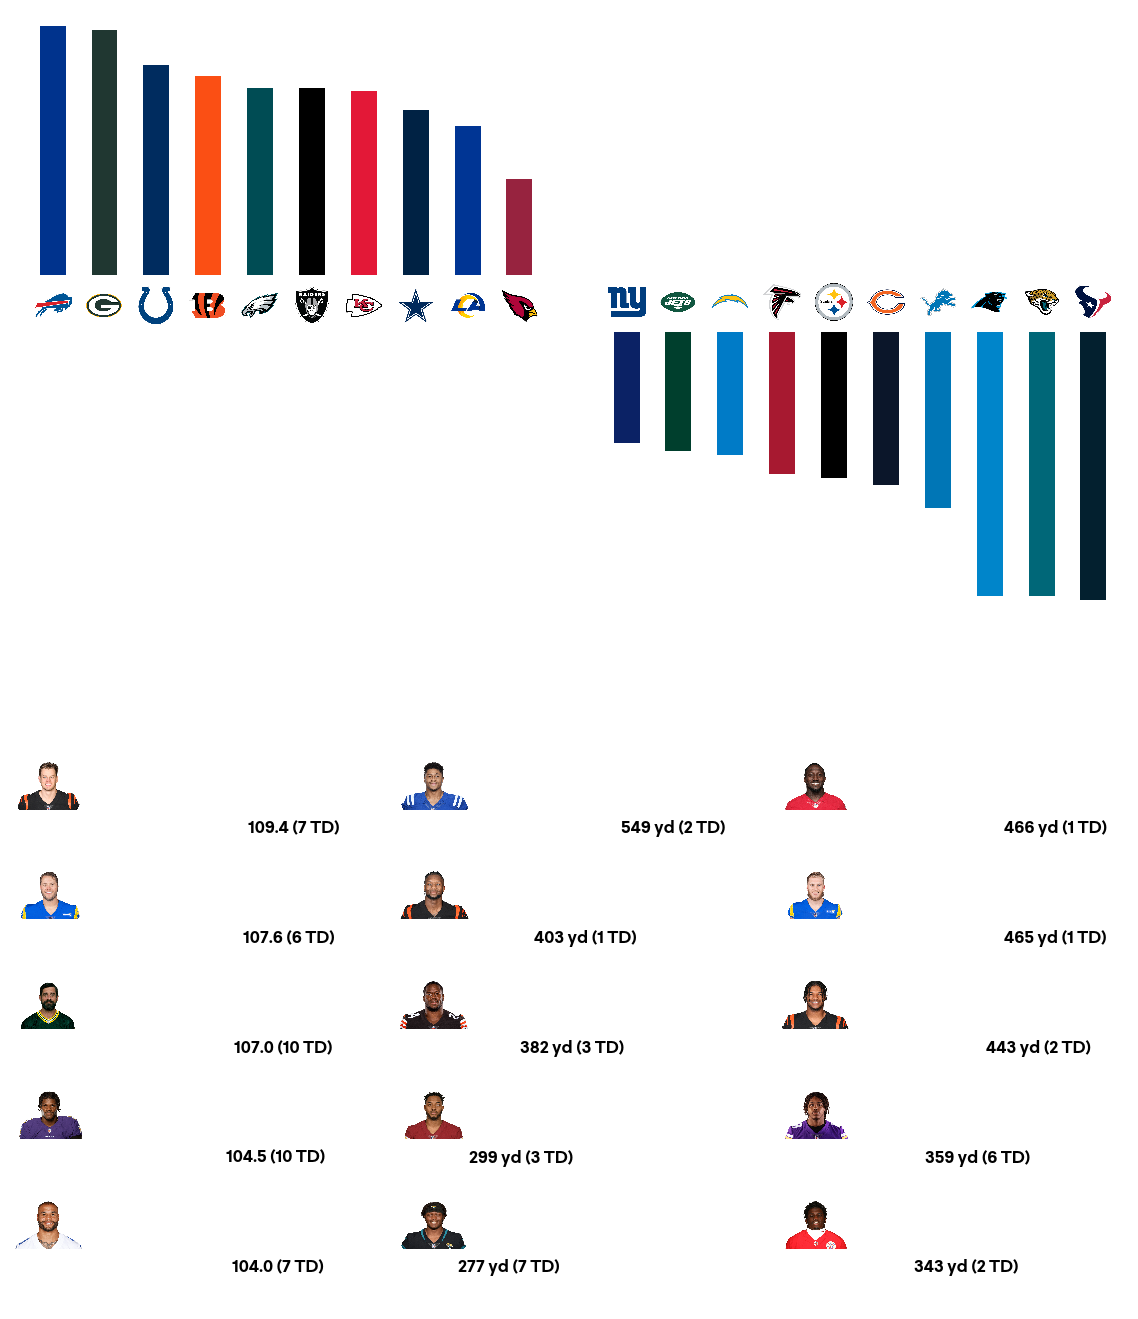

In [168]:
plt.rcParams["font.family"] = "Larsseit"
plt.rcParams["font.size"] = 16

NUMBER_OF_TEAMS = 32

fig = plt.figure(figsize=(20, 24), facecolor="w")
gs = fig.add_gridspec(nrows=2, ncols=6, height_ratios=[1, 1])

ax_pts_top = fig.add_subplot(gs[0, :3], frame_on=False)
ax_pts_bottom = fig.add_subplot(gs[0, 3:], frame_on=False)
ax_pass = fig.add_subplot(gs[1, :2], frame_on=False)
ax_rush = fig.add_subplot(gs[1, 2:4], frame_on=False)
ax_rec = fig.add_subplot(gs[1, 4:], frame_on=False)

# Point Differential
ax_pts_top.bar(range(10), df_3q_pts.head(10)["pts_diff"], width=0.5, color=df_3q_pts.head(10)["team_color"])
ax_pts_bottom.bar(range(10), df_3q_pts.tail(10)["pts_diff"], width=0.5, color=df_3q_pts.tail(10)["team_color"])

# Add bar annotations
for i, val in enumerate(df_3q_pts.head(10)["pts_diff"]):
    ax_pts_top.text(i, val + 2, val, ha="center", va="baseline", fontweight=600, color="w")
    
    # Logos
    team = df_3q_pts.iloc[i].team
    im = np.array(Image.open(f"./logos/{team}.png"))
    xy = [i, -8]
    imbox = OffsetImage(im, zoom=0.08)
    imbox.image.axes = ax_pts_top
    
    ab = AnnotationBbox(
        imbox, xy,
        frameon=False
    )
    
    ax_pts_top.add_artist(ab)
    
for i, val in enumerate(df_3q_pts.tail(10)["pts_diff"]):
    ax_pts_bottom.text(i, val - 2, val, ha="center", va="top", fontweight=600, color="w")
    
    # Logos
    low_index = i + (NUMBER_OF_TEAMS - 10)
    team = df_3q_pts.iloc[low_index].team
    im = np.array(Image.open(f"./logos/{team}.png"))
    xy = [i, 8]
    imbox = OffsetImage(im, zoom=0.08)
    imbox.image.axes = ax_pts_bottom
    
    ab = AnnotationBbox(
        imbox, xy,
        frameon=False
    )
    
    ax_pts_bottom.add_artist(ab)
    
# Top Passers
ax_pass.barh(range(5), df_3q_pass.head(5)["passer_rating"][::-1], height=0.3, color="w")
ax_pass.set(ylim=[-0.4, 5])

for i, val in enumerate(df_3q_pass.head(5)["passer_rating"][::-1]):
    ax_pass.text(val - 3, i, f"{val} ({int(df_3q_pass.iloc[i].tds)} TD)", ha="right", va="center", fontsize=18, fontweight=600)
    
    # Headshots
    reindex = 4 - i
    player_id = df_3q_pass.iloc[reindex].gsis_id
    im = np.array(Image.open(f"./headshots/{player_id}.png").convert("RGBA"))
    xy = [11, i + 0.4]
    imbox = OffsetImage(im, zoom=0.05)
    imbox.image.axes = ax_pass
    
    ab = AnnotationBbox(
        imbox, xy,
        frameon=False
    )
    
    ax_pass.add_artist(ab)
    
    # Player Names
    ax_pass.text(
        28, i + 0.3,
        df_3q_pass.iloc[reindex].full_name,
        ha="left",
        va="center",
        color="w",
        fontsize=20,
        fontweight=600
    )
    
ax_pass.set_title("Passer Rating (min. 25 attempts)", loc="center", fontsize=23, fontweight=600, color="w")

    
# Top Rushers
ax_rush.barh(range(5), df_3q_rush.head(5)["yds"][::-1], height=0.3, color="w")
ax_rush.set(ylim=[-0.4, 5])

for i, val in enumerate(df_3q_rush.head(5)["yds"][::-1]):
    ax_rush.text(val - 10, i, f"{int(val)} yd ({int(df_3q_rush.iloc[i].tds)} TD)", ha="right", va="center", fontsize=18, fontweight=600)
    
    # Headshots
    reindex = 4 - i
    player_id = df_3q_rush.iloc[reindex].gsis_id
    im = np.array(Image.open(f"./headshots/{player_id}.png").convert("RGBA"))
    xy = [60, i + 0.4]
    imbox = OffsetImage(im, zoom=0.05)
    imbox.image.axes = ax_rush
    
    ab = AnnotationBbox(
        imbox, xy,
        frameon=False
    )
    
    ax_rush.add_artist(ab)
    
    # Player Names
    ax_rush.text(
        140, i + 0.3,
        df_3q_rush.iloc[reindex].full_name,
        ha="left",
        va="center",
        color="w",
        fontsize=20,
        fontweight=600
    )
    
ax_rush.set_title("Rushing Yards", loc="center", color="w", fontsize=23, fontweight=600)

# Top Receivers
ax_rec.barh(range(5), df_3q_rec.head(5)["yds"][::-1], height=0.3, color="w")
ax_rec.set(ylim=[-0.4, 5])

for i, val in enumerate(df_3q_rec.head(5)["yds"][::-1]):
    ax_rec.text(val - 10, i, f"{int(val)} yd ({int(df_3q_rec.iloc[i].tds)} TD)", ha="right", va="center", fontsize=18, fontweight=600)
    
    # Headshots
    reindex = 4 - i
    player_id = df_3q_rec.iloc[reindex].gsis_id
    im = np.array(Image.open(f"./headshots/{player_id}.png").convert("RGBA"))
    xy = [50, i + 0.4]
    imbox = OffsetImage(im, zoom=0.05)
    imbox.image.axes = ax_rec
    
    ab = AnnotationBbox(
        imbox, xy,
        frameon=False
    )
    
    ax_rec.add_artist(ab)
    
    # Player Names
    ax_rec.text(
        115, i + 0.3,
        df_3q_rec.iloc[reindex].full_name,
        ha="left",
        va="center",
        color="w",
        fontsize=20,
        fontweight=600
    )
    
ax_rec.set_title("Receiving Yards", loc="center", color="w", fontsize=23, fontweight=600)

ax_pts_top.set(xticks=[], yticks=[], ylim=[-85, 70])
ax_pts_bottom.set(xticks=[], yticks=[], ylim=[-70, 85])
ax_pass.set(xticks=[], yticks=[])
ax_rush.set(xticks=[], yticks=[])
ax_rec.set(xticks=[], yticks=[])

#plt.savefig("test.png", dpi=300, bbox_inches="tight")
plt.show()